In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import math
import functools
import matplotlib.pyplot as plt

# term definitions
## variable terms
|variable | description |
|---------| ----------- |
| time | time for diffusion to occur in (mins), written as (minimum time : maximum time) |
| CAS | starting concentration at surface in(μM)|
|gel | gel thickness in(μm)
|temp| temperature in(◦C)|
|dyvisc |dynamic viscoscity of buffer/media in(kg/m·s)or(Pa·s)|
|rad |radius of solute in(nm)|
|dpore | diameter of gel pore in(nm)|

## constant terms
|variable | description |
|---------| ----------- |
|Boltz| bolltzmann Constant (1.38064852 x10−23)|
|k_to_c |Conversion from(◦C)to Kelvin (273.15)|

## Terms in Function:

* (Boltz* (temp+273.15)/(6* pi* dyvisc* rad))* 60e+21= Stokes einstein equation/diffusion coefficient(μm2/s)
* (1 -ψ)2= Steric partition coefficient(F1(ψ))
* 1 - (2.104 *ψ) + (2.09 *ψ3) - (0.95 *ψ5)= Hydrodynamic hinderance factor(F2(ψ))
* rad * 2/dpore=ψCAS·1 - erf(x√4·2D·t)= solution to Fick’s second law (∂C∂t= 2D·∂2C∂x2) for * two-sided diffusion boundary conditions (x=0,c=CAS; x>0, c = 0; t=0)



# physical constants

In [16]:
# constants
boltz = 1.38064852e-23
pi = np.pi

# molecule specific variables
* cas - concentration at surface, uM
* rad - radius of solute, nm

In [14]:
# name , concentration_at_surface_um, radius_of_molecule_nm
solutes = [
    ['dNTPs', 200, .34],
    ['MgCl2',1500, .253],
    ['fwdPrimer',1,1.26],
    ['revPrimer', 1,1.13],
    ['Taq',7e-09,4.6]]

# pore size
"At low %T (typical for DNA sequencing gels), the higher proportion of crosslinker makes the gel stronger. At a higher %T (typical for proteins; 10–12% T), using 5% C makes the gel brittle and it cracks more easily. Using a lower %C makes a 10–12% T gel more elastic and flexible without loss of strength. "
Pore size is predominantly a function of gel percentage. It is affected by the monomer ratio if it goes below 6%, but otherwise is primarily determined by the monomer:water ratio.

In [31]:
#WIP
# % t = (g acrylamied + g cross-linker) / total volume (mL) x100
np.reciprocal(6.0)*100

16.666666666666664

# diffusion function definition

In [12]:
def twosidedDiffusion(time,temp, dpore, dyvisc, gel,cas, rad):
    tempK = temp + 273.15
    
    stokes = boltz* tempK/(6* pi* dyvisc* rad)* 60e+21
    
    psi = (rad*2)/dpore
    steric_partition = np.power(1-psi, 2)
    hindrance = 1 - (2.104 * psi) + np.power(2.09*psi,3) - np.power(0.95*psi, 5)
    D = stokes*steric_partition*hindrance
    _denom = np.sqrt(4*2*D*time)
    c_as = 1-math.erf(gel/_denom)
    c_as_time = cas * c_as
    return c_as_time, c_as

# set environmental conditions + model

In [15]:
time = 210
temp = 4
dyvisc = 0.001569 # this can be variable, but it is constant for now
dpore = 56
gel = 50
diffusionFunc = functools.partial(twosidedDiffusion, time, temp, dpore, dyvisc, gel)

print("At {} minutes and incubation at {}*c, concentration at center is:".format(time, temp))
for c in solutes:
    title = c[0]
    val, ratio = diffusionFunc(cas = c[1], rad = c[2])
    if title == "Taq":
        printVal = "{:e}".format(val)
    else:
        printVal = np.round(val, 4)
    print("{}: {} interior (uM), {} of surface".format(title,
                                                       printVal,
                                                       np.round(ratio, 5)))

At 210 minutes and incubation at 4*c, concentration at center is:
dNTPs: 198.1349 interior (uM), 0.99067 of surface
MgCl2: 1488.0059 interior (uM), 0.992 of surface
fwdPrimer: 0.9808 interior (uM), 0.98084 of surface
revPrimer: 0.982 interior (uM), 0.98202 of surface
Taq: 6.671473e-09 interior (uM), 0.95307 of surface


# plotting time vs concentration for all components

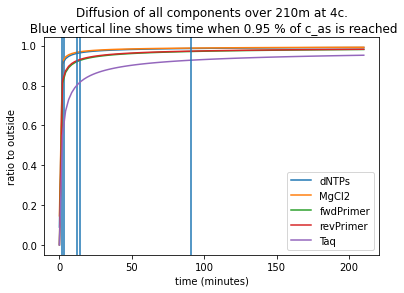

In [7]:
x = np.linspace(.01,time,100)
vectorizedDiffusion = np.vectorize(twosidedDiffusion) 
fig, ax = plt.subplots()
goal_c_as = .95

for c in solutes:
    title = c[0]
    val, ratio = vectorizedDiffusion(x, temp, dpore, dyvisc, gel, cas = c[1], rad = c[2])
    ax = sns.lineplot(x=x, y = ratio, ax = ax, legend='brief', label=title)
    idx = np.argwhere(np.diff(np.sign(goal_c_as - ratio))).flatten()
    ax.axvline(x = idx)    

ax.set(xlabel='time (minutes)', ylabel='ratio to outside')
ax.set_title("Diffusion of all components over {}m at {}c.\n Blue vertical line shows time when {} % of c_as is reached".format(time, temp, goal_c_as))
# plt.plot(x[idx], f[idx], 'ro')
plt.show()